In [1]:
import json
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from tqdm import tqdm
import os

D:\py\py_evl\LLMelog\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class QADataset(Dataset):
    def __init__(self, file_path, tokenizer, max_input_len=512, max_output_len=64):
        self.samples = []
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_output_len = max_output_len

        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                self.samples.append(json.loads(line.strip()))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        input_text = f"问题: {sample['question']} 上下文: {sample['context']}"
        target_text = sample["answer"]

        model_inputs = self.tokenizer(
            input_text,
            max_length=self.max_input_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        labels = self.tokenizer(
            target_text,
            max_length=self.max_output_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        model_inputs["labels"] = labels["input_ids"].squeeze()
        return {key: val.squeeze() for key, val in model_inputs.items()}


In [ ]:
def train(model, tokenizer, train_dataset, val_dataset=None, epochs=3, batch_size=8, lr=3e-5, device="cuda"):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    if val_dataset:
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 记录 loss
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        print("-" * 30)

        # 训练
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))

        for i, batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_description(f"loss: {loss.item():.6f}")

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        print(f"Epoch {epoch} Training Loss: {epoch_train_loss:.6f}")

        # 验证
        if val_dataset:
            model.eval()
            val_loss_total = 0.0
            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validation"):
                    input_ids = batch["input_ids"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    labels = batch["labels"].to(device)

                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    val_loss_total += outputs.loss.item()

            val_loss = val_loss_total / len(val_loader)
            val_losses.append(val_loss)
            print(f"Epoch {epoch} Validation Loss: {val_loss:.6f}")

        # 保存模型（每个 epoch）
        save_dir = f"./qa_t5_epoch{epoch}"
        os.makedirs(save_dir, exist_ok=True)
        model.save_pretrained(save_dir)
        tokenizer.save_pretrained(save_dir)
        print(f"模型已保存到 {save_dir}")

    return train_losses, val_losses

In [ ]:
# 主函数
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", device)
model_name = "langboat/mengzi-t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
    # 打印模型信息
print("\n===== 模型信息 =====")
print(model)
print("===================")

device:  cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
D:\py\py_evl\LLMelog\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\legend5259\.cache\huggingface\hub\models--langboat--mengzi-t5-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https


===== 模型信息 =====
T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
 

In [ ]:
# 数据集

train_dataset = QADataset("./data/DuReaderQG/train.json", tokenizer)
val_dataset = QADataset("./data/DuReaderQG/dev.json", tokenizer)

print(f"\n训练集大小: {len(train_dataset)} 条")
print(f"验证集大小: {len(val_dataset)} 条")

# 打印训练集前三条样本
print("\n===== 训练集样本展示 =====")
for i in range(min(3, len(train_dataset))):
    sample = train_dataset.samples[i]
    print(f"\n样本 {i+1}:")
    print("问题:", sample["question"])
    print("上下文:", sample["context"][:80], "..." if len(sample["context"]) > 80 else "")
    print("答案:", sample["answer"])
    encoded = tokenizer(
        f"问题: {sample['question']} 上下文: {sample['context']}",
        max_length=64,
        truncation=True
    )
    print("input_ids:", encoded["input_ids"][:20], "...")


训练集大小: 14520 条
验证集大小: 984 条

===== 训练集样本展示 =====

样本 1:
问题: 仙剑奇侠传3第几集上天界
上下文: 第35集雪见缓缓张开眼睛，景天又惊又喜之际，长卿和紫萱的仙船驶至，见众人无恙，也十分高兴。众人登船，用尽合力把自身的真气和水分输给她。雪见终于醒过来了，但却一脸 ...
答案: 第35集
input_ids: [143, 13, 7, 1707, 1467, 992, 3979, 707, 100, 379, 645, 647, 9724, 1252, 7, 2868, 180, 13, 3389, 2838] ...

样本 2:
问题: 燃气热水器哪个牌子好
上下文: 选择燃气热水器时，一定要关注这几个问题：1、出水稳定性要好，不能出现忽热忽冷的现象2、快速到达设定的需求水温3、操作要智能、方便4、安全性要好，要装有安全报警装 ...
答案: 方太
input_ids: [143, 13, 7, 9147, 14702, 2347, 8245, 67, 7, 2868, 180, 13, 7, 188, 9147, 14702, 40, 3, 683, 668] ...

样本 3:
问题: 乔丹打了多少个赛季
上下文: 迈克尔.乔丹在NBA打了15个赛季。他在84年进入nba，期间在1993年10月6日第一次退役改打棒球，95年3月18日重新回归，在99年1月13日第二次退役， ...
答案: 15个
input_ids: [143, 13, 7, 19918, 176, 8986, 19940, 7, 2868, 180, 13, 7, 25659, 2250, 19918, 8, 18820, 5719, 672, 19940] ...


In [7]:
train_losses, val_losses = train(
    model,
    tokenizer,
    train_dataset,
    val_dataset=val_dataset,
    epochs=30,
    batch_size=8,
    lr=3e-5,
    device=device
)


Epoch 1/30
------------------------------


loss: 0.085750: 100%|██████████| 1815/1815 [04:37<00:00,  6.54it/s]


Epoch 1 Training Loss: 0.242503


Validation: 100%|██████████| 123/123 [00:06<00:00, 18.49it/s]


Epoch 1 Validation Loss: 0.067900
模型已保存到 ./qa_t5_epoch1

Epoch 2/30
------------------------------


loss: 0.028397: 100%|██████████| 1815/1815 [04:36<00:00,  6.57it/s]


Epoch 2 Training Loss: 0.035600


Validation: 100%|██████████| 123/123 [00:06<00:00, 19.07it/s]


Epoch 2 Validation Loss: 0.069697
模型已保存到 ./qa_t5_epoch2

Epoch 3/30
------------------------------


loss: 0.024963: 100%|██████████| 1815/1815 [04:57<00:00,  6.10it/s]


Epoch 3 Training Loss: 0.022957


Validation: 100%|██████████| 123/123 [00:07<00:00, 16.68it/s]


Epoch 3 Validation Loss: 0.073981
模型已保存到 ./qa_t5_epoch3

Epoch 4/30
------------------------------


loss: 0.008388: 100%|██████████| 1815/1815 [05:41<00:00,  5.32it/s]


Epoch 4 Training Loss: 0.016565


Validation: 100%|██████████| 123/123 [00:07<00:00, 16.67it/s]


Epoch 4 Validation Loss: 0.079670
模型已保存到 ./qa_t5_epoch4

Epoch 5/30
------------------------------


loss: 0.011446: 100%|██████████| 1815/1815 [05:22<00:00,  5.62it/s]


Epoch 5 Training Loss: 0.010805


Validation: 100%|██████████| 123/123 [00:11<00:00, 10.64it/s]


Epoch 5 Validation Loss: 0.085940
模型已保存到 ./qa_t5_epoch5

Epoch 6/30
------------------------------


loss: 0.000868: 100%|██████████| 1815/1815 [07:51<00:00,  3.85it/s]


Epoch 6 Training Loss: 0.009070


Validation: 100%|██████████| 123/123 [00:12<00:00,  9.55it/s]


Epoch 6 Validation Loss: 0.088844
模型已保存到 ./qa_t5_epoch6

Epoch 7/30
------------------------------


loss: 0.001060: 100%|██████████| 1815/1815 [10:22<00:00,  2.91it/s]


Epoch 7 Training Loss: 0.007180


Validation: 100%|██████████| 123/123 [00:16<00:00,  7.57it/s]


Epoch 7 Validation Loss: 0.097251
模型已保存到 ./qa_t5_epoch7

Epoch 8/30
------------------------------


loss: 0.001616: 100%|██████████| 1815/1815 [09:10<00:00,  3.30it/s]


Epoch 8 Training Loss: 0.006255


Validation: 100%|██████████| 123/123 [00:07<00:00, 16.97it/s]


Epoch 8 Validation Loss: 0.101020
模型已保存到 ./qa_t5_epoch8

Epoch 9/30
------------------------------


loss: 0.036825: 100%|██████████| 1815/1815 [05:23<00:00,  5.61it/s]


Epoch 9 Training Loss: 0.005385


Validation: 100%|██████████| 123/123 [00:10<00:00, 11.80it/s]


Epoch 9 Validation Loss: 0.105960
模型已保存到 ./qa_t5_epoch9

Epoch 10/30
------------------------------


loss: 0.003957: 100%|██████████| 1815/1815 [07:18<00:00,  4.14it/s]


Epoch 10 Training Loss: 0.004779


Validation: 100%|██████████| 123/123 [00:13<00:00,  9.00it/s]


Epoch 10 Validation Loss: 0.107193
模型已保存到 ./qa_t5_epoch10

Epoch 11/30
------------------------------


loss: 0.001165: 100%|██████████| 1815/1815 [11:06<00:00,  2.72it/s]


Epoch 11 Training Loss: 0.004373


Validation: 100%|██████████| 123/123 [00:23<00:00,  5.28it/s]


Epoch 11 Validation Loss: 0.106175
模型已保存到 ./qa_t5_epoch11

Epoch 12/30
------------------------------


loss: 0.003393: 100%|██████████| 1815/1815 [12:49<00:00,  2.36it/s]


Epoch 12 Training Loss: 0.004191


Validation: 100%|██████████| 123/123 [00:19<00:00,  6.24it/s]


Epoch 12 Validation Loss: 0.103141
模型已保存到 ./qa_t5_epoch12

Epoch 13/30
------------------------------


loss: 0.000127: 100%|██████████| 1815/1815 [14:39<00:00,  2.06it/s]


Epoch 13 Training Loss: 0.003650


Validation: 100%|██████████| 123/123 [00:17<00:00,  6.84it/s]


Epoch 13 Validation Loss: 0.109772
模型已保存到 ./qa_t5_epoch13

Epoch 14/30
------------------------------


loss: 0.001937: 100%|██████████| 1815/1815 [12:49<00:00,  2.36it/s]


Epoch 14 Training Loss: 0.003127


Validation: 100%|██████████| 123/123 [00:11<00:00, 10.30it/s]


Epoch 14 Validation Loss: 0.112435
模型已保存到 ./qa_t5_epoch14

Epoch 15/30
------------------------------


loss: 0.017781: 100%|██████████| 1815/1815 [14:54<00:00,  2.03it/s]


Epoch 15 Training Loss: 0.003075


Validation: 100%|██████████| 123/123 [00:21<00:00,  5.61it/s]


Epoch 15 Validation Loss: 0.122508
模型已保存到 ./qa_t5_epoch15

Epoch 16/30
------------------------------


loss: 0.006477: 100%|██████████| 1815/1815 [18:38<00:00,  1.62it/s]


Epoch 16 Training Loss: 0.003003


Validation: 100%|██████████| 123/123 [00:34<00:00,  3.56it/s]


Epoch 16 Validation Loss: 0.116610
模型已保存到 ./qa_t5_epoch16

Epoch 17/30
------------------------------


loss: 0.027605: 100%|██████████| 1815/1815 [19:17<00:00,  1.57it/s]


Epoch 17 Training Loss: 0.002691


Validation: 100%|██████████| 123/123 [00:27<00:00,  4.49it/s]


Epoch 17 Validation Loss: 0.115965
模型已保存到 ./qa_t5_epoch17

Epoch 18/30
------------------------------


loss: 0.000153: 100%|██████████| 1815/1815 [11:07<00:00,  2.72it/s]


Epoch 18 Training Loss: 0.002663


Validation: 100%|██████████| 123/123 [00:07<00:00, 16.41it/s]


Epoch 18 Validation Loss: 0.119518
模型已保存到 ./qa_t5_epoch18

Epoch 19/30
------------------------------


loss: 0.001575: 100%|██████████| 1815/1815 [09:51<00:00,  3.07it/s]


Epoch 19 Training Loss: 0.002245


Validation: 100%|██████████| 123/123 [00:16<00:00,  7.58it/s]


Epoch 19 Validation Loss: 0.120485
模型已保存到 ./qa_t5_epoch19

Epoch 20/30
------------------------------


loss: 0.000663: 100%|██████████| 1815/1815 [10:47<00:00,  2.80it/s]


Epoch 20 Training Loss: 0.002212


Validation: 100%|██████████| 123/123 [00:11<00:00, 10.49it/s]


Epoch 20 Validation Loss: 0.124605
模型已保存到 ./qa_t5_epoch20

Epoch 21/30
------------------------------


loss: 0.001038: 100%|██████████| 1815/1815 [08:01<00:00,  3.77it/s]


Epoch 21 Training Loss: 0.002212


Validation: 100%|██████████| 123/123 [00:09<00:00, 12.38it/s]


Epoch 21 Validation Loss: 0.121190
模型已保存到 ./qa_t5_epoch21

Epoch 22/30
------------------------------


loss: 0.000276: 100%|██████████| 1815/1815 [06:44<00:00,  4.49it/s]


Epoch 22 Training Loss: 0.002042


Validation: 100%|██████████| 123/123 [00:09<00:00, 12.51it/s]


Epoch 22 Validation Loss: 0.127119
模型已保存到 ./qa_t5_epoch22

Epoch 23/30
------------------------------


loss: 0.000139: 100%|██████████| 1815/1815 [06:44<00:00,  4.49it/s]


Epoch 23 Training Loss: 0.002117


Validation: 100%|██████████| 123/123 [00:09<00:00, 12.45it/s]


Epoch 23 Validation Loss: 0.132873
模型已保存到 ./qa_t5_epoch23

Epoch 24/30
------------------------------


loss: 0.000131: 100%|██████████| 1815/1815 [06:43<00:00,  4.49it/s]


Epoch 24 Training Loss: 0.001916


Validation: 100%|██████████| 123/123 [00:09<00:00, 12.43it/s]


Epoch 24 Validation Loss: 0.138551
模型已保存到 ./qa_t5_epoch24

Epoch 25/30
------------------------------


loss: 0.005010: 100%|██████████| 1815/1815 [05:05<00:00,  5.95it/s]


Epoch 25 Training Loss: 0.002057


Validation: 100%|██████████| 123/123 [00:06<00:00, 18.37it/s]


Epoch 25 Validation Loss: 0.134292
模型已保存到 ./qa_t5_epoch25

Epoch 26/30
------------------------------


loss: 0.030839: 100%|██████████| 1815/1815 [04:58<00:00,  6.08it/s]


Epoch 26 Training Loss: 0.001858


Validation: 100%|██████████| 123/123 [00:08<00:00, 14.06it/s]


Epoch 26 Validation Loss: 0.134069
模型已保存到 ./qa_t5_epoch26

Epoch 27/30
------------------------------


loss: 0.009863: 100%|██████████| 1815/1815 [05:05<00:00,  5.95it/s]


Epoch 27 Training Loss: 0.001747


Validation: 100%|██████████| 123/123 [00:06<00:00, 18.06it/s]


Epoch 27 Validation Loss: 0.138696
模型已保存到 ./qa_t5_epoch27

Epoch 28/30
------------------------------


loss: 0.000543: 100%|██████████| 1815/1815 [04:44<00:00,  6.39it/s]


Epoch 28 Training Loss: 0.001865


Validation: 100%|██████████| 123/123 [00:06<00:00, 18.89it/s]


Epoch 28 Validation Loss: 0.135327
模型已保存到 ./qa_t5_epoch28

Epoch 29/30
------------------------------


loss: 0.000268: 100%|██████████| 1815/1815 [04:50<00:00,  6.26it/s]


Epoch 29 Training Loss: 0.001502


Validation: 100%|██████████| 123/123 [00:06<00:00, 19.10it/s]


Epoch 29 Validation Loss: 0.130580
模型已保存到 ./qa_t5_epoch29

Epoch 30/30
------------------------------


loss: 0.000243: 100%|██████████| 1815/1815 [04:51<00:00,  6.23it/s]


Epoch 30 Training Loss: 0.001400


Validation: 100%|██████████| 123/123 [00:06<00:00, 18.21it/s]


Epoch 30 Validation Loss: 0.136403
模型已保存到 ./qa_t5_epoch30


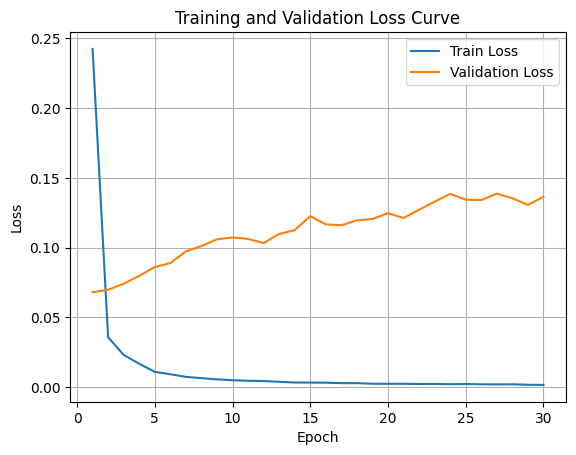

Loss 曲线已保存为 loss_curve.png


<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

# -----------------------------
# 绘制并显示 loss 曲线
# -----------------------------
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
if val_losses:
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)

# 在 notebook 中显示
plt.show()

# 同时保存图片
plt.savefig("loss_curve.png")
print("Loss 曲线已保存为 loss_curve.png")